# Model training

In [1]:
import torch
from torch import nn
import pandas as pd

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Load data

X_train = pd.read_csv("./../data/features/in_features_train.csv")
X_train_pca = pd.read_csv("./../data/features/pca_in_features_train.csv")

X_train.shape, X_train_pca.shape

((145, 2593), (145, 61))

In [4]:
y_train = pd.read_csv("./../data/features/out_features_train.csv").label
y_train_pca = pd.read_csv("./../data/features/pca_out_features_train.csv").label

y_train.shape, y_train_pca.shape

((145,), (145,))

In [5]:
X_test = pd.read_csv("./../data/features/in_features_test.csv")
X_test_pca = pd.read_csv("./../data/features/pca_in_features_test.csv")

X_test.shape, X_test_pca.shape

((16, 2593), (16, 61))

In [6]:
y_test = pd.read_csv("./../data/features/out_features_test.csv").label

y_test.shape

(16,)

## Support Vector Machine (SVM)

### Non PCA features

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold

svm = SVC(kernel='rbf', C=10, gamma=0.01)
# p_grid = {"C": [1, 10, 20, 50, 100], "gamma": [0.01, 0.1, 0.2, 0.4, 0.6, 0.8]}
# cv = KFold(n_splits=5, shuffle=True)

# clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring="f1_macro")
# clf.fit(X_train, y_train)

clf = svm.fit(X_train, y_train)

In [8]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0], dtype=int64)

In [9]:
y_test.to_numpy()

array([2, 2, 0, 0, 0, 2, 0, 1, 3, 1, 2, 0, 1, 0, 0, 0], dtype=int64)

In [10]:
from modules.engine import get_metrics
svm_train_metrics = get_metrics(y_train, clf.predict(X_train))

Accuracy:  0.8689655172413793  | F1-score:  0.8692980296196385  | Precision:  0.8928321678321678  | Recall:  0.8689655172413794


In [11]:
# Evaluate
svm_test_metrics = get_metrics(y_test, y_pred)

Accuracy:  0.5  | F1-score:  0.28421052631578947  | Precision:  0.28409090909090906  | Recall:  0.3020833333333333


In [12]:
clf.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [13]:
import joblib
from pathlib import Path


# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "svm.pk"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

joblib.dump(clf, MODEL_SAVE_PATH)

['models\\svm.pk']

### PCA features


In [14]:
svm = SVC(kernel='rbf', C=20, gamma=0.01)
# p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}
# cv = KFold(n_splits=5, shuffle=True)

# clf_pca = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring="f1_macro")
# clf_pca.fit(X_train_pca, y_train)

clf_pca = svm.fit(X_train_pca, y_train_pca)

In [15]:
y_pred = clf_pca.predict(X_test_pca)

In [16]:
y_test.to_numpy()

array([2, 2, 0, 0, 0, 2, 0, 1, 3, 1, 2, 0, 1, 0, 0, 0], dtype=int64)

In [17]:
svm_pca_train_metrics = get_metrics(y_train, clf_pca.predict(X_train_pca))

Accuracy:  0.9793103448275862  | F1-score:  0.9791873019779139  | Precision:  0.9792939244663383  | Recall:  0.9793103448275862


In [18]:
# Evaluate
svm_pca_test_metrics = get_metrics(y_test, y_pred)

Accuracy:  0.5  | F1-score:  0.27777777777777773  | Precision:  0.2583333333333333  | Recall:  0.3020833333333333


## Linear model

## Non-PCA

In [19]:
X_train = torch.from_numpy(X_train.to_numpy()).type(torch.float)
X_test = torch.from_numpy(X_test.to_numpy()).type(torch.float)

classes = y_train.unique()

y_train = torch.from_numpy(y_train.to_numpy()).type(torch.LongTensor)
y_test = torch.from_numpy(y_test.to_numpy()).type(torch.LongTensor)

in_features, out_features = X_train.shape[1], len(classes)
in_features, out_features

(2593, 5)

In [20]:
from modules.model_builder import BaseModel

model_0 = BaseModel(in_features, 50, out_features).to(device)

In [21]:
from modules.engine import train, save_model

loss_fn = nn.CrossEntropyLoss()
optimizer_class = torch.optim.SGD

train(model_0, X_train, X_test, y_train, y_test,
      loss_fn, optimizer_class, epochs=500, lr=0.1, device=device, verbose=True)

Epoch: 0
Accuracy:  0.5  | F1-score:  0.16666666666666666  | Precision:  0.25  | Recall:  0.125
Train Loss: 1.613455891609192 | Test loss: 1.6084201335906982
---------------------------------------------------------
Epoch: 100
Accuracy:  0.0625  | F1-score:  0.1  | Precision:  0.08333333333333333  | Recall:  0.125
Train Loss: 1.5938336849212646 | Test loss: 1.6074047088623047
---------------------------------------------------------
Epoch: 200
Accuracy:  0.0625  | F1-score:  0.029411764705882353  | Precision:  0.25  | Recall:  0.015625
Train Loss: 1.4286532402038574 | Test loss: 1.5732977390289307
---------------------------------------------------------
Epoch: 300
Accuracy:  0.1875  | F1-score:  0.1625  | Precision:  0.14583333333333331  | Recall:  0.3
Train Loss: 1.0482500791549683 | Test loss: 1.4468497037887573
---------------------------------------------------------
Epoch: 400
Accuracy:  0.3125  | F1-score:  0.23737373737373738  | Precision:  0.23958333333333331  | Recall:  0.331

In [22]:
model_0.eval()
with torch.inference_mode():
    y_train_logits = model_0(X_train.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_0(X_test.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [23]:

mlp_train_metrics = get_metrics(y_train, y_train_pred)

Accuracy:  0.9586206896551724  | F1-score:  0.9573531844499585  | Precision:  0.9628543499511242  | Recall:  0.9586206896551724


In [24]:

mlp_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.5  | F1-score:  0.3263888888888889  | Precision:  0.3208333333333333  | Recall:  0.3333333333333333


In [25]:
save_model(model_0, "mlp.pth")

Saving model to: models\mlp.pth


## PCA Model

In [26]:
X_train_pca = torch.from_numpy(X_train_pca.to_numpy()).type(torch.float)
X_test_pca = torch.from_numpy(X_test_pca.to_numpy()).type(torch.float)

y_train_pca = torch.from_numpy(y_train_pca.to_numpy()).type(torch.LongTensor)



In [27]:
in_features_pca = X_train_pca.shape[1]
in_features_pca, out_features

(61, 5)

In [28]:
model_0_pca = BaseModel(in_features_pca, 50, out_features).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer_class = torch.optim.SGD

train(model_0_pca, X_train_pca, X_test_pca, y_train, y_test,
      loss_fn, optimizer_class, 500, 0.1, device, verbose=True)

Epoch: 0
Accuracy:  0.0625  | F1-score:  0.029411764705882353  | Precision:  0.25  | Recall:  0.015625
Train Loss: 1.6204228401184082 | Test loss: 1.6019619703292847
---------------------------------------------------------
Epoch: 100
Accuracy:  0.1875  | F1-score:  0.13333333333333333  | Precision:  0.22916666666666666  | Recall:  0.09722222222222221
Train Loss: 1.5715495347976685 | Test loss: 1.5924378633499146
---------------------------------------------------------
Epoch: 200
Accuracy:  0.25  | F1-score:  0.1437908496732026  | Precision:  0.28125  | Recall:  0.30357142857142855
Train Loss: 1.2032582759857178 | Test loss: 1.4648252725601196
---------------------------------------------------------
Epoch: 300
Accuracy:  0.4375  | F1-score:  0.26666666666666666  | Precision:  0.32291666666666663  | Recall:  0.25
Train Loss: 0.9320446252822876 | Test loss: 1.3229973316192627
---------------------------------------------------------
Epoch: 400
Accuracy:  0.375  | F1-score:  0.238095238

In [29]:
model_0_pca.eval()
with torch.inference_mode():
    y_train_logits = model_0_pca(X_train_pca.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_0_pca(X_test_pca.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [30]:
mlp_pca_train_metrics = get_metrics(y_train, y_train_pred)

Accuracy:  0.9724137931034482  | F1-score:  0.9723809523809525  | Precision:  0.9732377538829151  | Recall:  0.9724137931034484


In [31]:
mlp_pca_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.5  | F1-score:  0.3320261437908497  | Precision:  0.3416666666666666  | Recall:  0.3333333333333333


In [32]:
save_model(model_0_pca, "mlp_pca.pth")

Saving model to: models\mlp_pca.pth


## Convolution Model

### Non-PCA

In [33]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [34]:
in_channels, in_length = X_train.shape[1:]
in_channels, in_length

(1, 2593)

In [35]:
from modules.model_builder import ConvModel

model_1 = ConvModel(in_channels, in_length, 50, out_features).to(device)

In [36]:
train(model_1, X_train, X_test, y_train, y_test,
      loss_fn, optimizer_class, 500, 0.1, device, verbose=True)

Epoch: 0
Accuracy:  0.5  | F1-score:  0.16666666666666666  | Precision:  0.25  | Recall:  0.125
Train Loss: 1.6098040342330933 | Test loss: 1.6017546653747559
---------------------------------------------------------
Epoch: 100
Accuracy:  0.25  | F1-score:  0.18681318681318682  | Precision:  0.17708333333333331  | Recall:  0.2125
Train Loss: 1.6060540676116943 | Test loss: 1.6085776090621948
---------------------------------------------------------
Epoch: 200
Accuracy:  0.375  | F1-score:  0.29166666666666663  | Precision:  0.3020833333333333  | Recall:  0.3333333333333333
Train Loss: 1.5215259790420532 | Test loss: 1.5765130519866943
---------------------------------------------------------
Epoch: 300
Accuracy:  0.5625  | F1-score:  0.30952380952380953  | Precision:  0.34375  | Recall:  0.30128205128205127
Train Loss: 1.6092803478240967 | Test loss: 1.6093225479125977
---------------------------------------------------------
Epoch: 400
Accuracy:  0.4375  | F1-score:  0.133333333333333

In [37]:
model_1.eval()
with torch.inference_mode():
    y_train_logits = model_1(X_train.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_1(X_test.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [38]:
cnn_train_metrics = get_metrics(y_train, y_train_pred)

Accuracy:  0.8275862068965517  | F1-score:  0.8106387371661317  | Precision:  0.8325847664006594  | Recall:  0.8275862068965518


In [39]:
cnn_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.25  | F1-score:  0.2077922077922078  | Precision:  0.3125  | Recall:  0.17708333333333331


In [40]:
save_model(model_1, "cnn.pth")

Saving model to: models\cnn.pth


### PCA

In [41]:
X_train_pca = X_train_pca.unsqueeze(1)
X_test_pca = X_test_pca.unsqueeze(1)

In [42]:
in_channels, in_length = X_train_pca.shape[1:]
in_channels, in_length

(1, 61)

In [43]:
model_1_pca = ConvModel(in_channels, in_length, 70, out_features).to(device)

In [44]:
train(model_1_pca, X_train_pca, X_test_pca, y_train_pca, y_test,
      loss_fn, optimizer_class, 500, 0.1, device, verbose=True)

Epoch: 0
Accuracy:  0.25  | F1-score:  0.1  | Precision:  0.25  | Recall:  0.0625
Train Loss: 1.609517216682434 | Test loss: 1.5992591381072998
---------------------------------------------------------


Epoch: 100
Accuracy:  0.375  | F1-score:  0.12  | Precision:  0.15  | Recall:  0.1
Train Loss: 1.602400779724121 | Test loss: 1.6084671020507812
---------------------------------------------------------
Epoch: 200
Accuracy:  0.0625  | F1-score:  0.04444444444444444  | Precision:  0.025  | Recall:  0.2
Train Loss: 1.4772064685821533 | Test loss: 1.5931000709533691
---------------------------------------------------------
Epoch: 300
Accuracy:  0.3125  | F1-score:  0.2366071428571429  | Precision:  0.23958333333333331  | Recall:  0.23958333333333331
Train Loss: 0.6558781266212463 | Test loss: 1.3878953456878662
---------------------------------------------------------
Epoch: 400
Accuracy:  0.4375  | F1-score:  0.2293233082706767  | Precision:  0.2708333333333333  | Recall:  0.19886363636363635
Train Loss: 0.1787809133529663 | Test loss: 1.8690922260284424
---------------------------------------------------------


In [45]:
model_1_pca.eval()
with torch.inference_mode():
    y_train_logits = model_1_pca(X_train_pca.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_1_pca(X_test_pca.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [46]:
cnn_pca_train_metrics = get_metrics(y_train_pca, y_train_pred)

Accuracy:  1.0  | F1-score:  1.0  | Precision:  1.0  | Recall:  1.0


In [47]:
cnn_pca_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.375  | F1-score:  0.20955882352941177  | Precision:  0.18888888888888888  | Recall:  0.23958333333333331


In [48]:
save_model(model_1_pca, "cnn_pca.pth")

Saving model to: models\cnn_pca.pth


## Summary

In [49]:
models_test_perf = [("SVM", *svm_train_metrics, *svm_test_metrics), 
                    ("SVM+PCA", *svm_pca_train_metrics, *svm_pca_test_metrics), 
                    ("MLP", *mlp_train_metrics, *mlp_test_metrics), 
                    ("MLP+PCA", *mlp_pca_train_metrics, *mlp_pca_test_metrics), 
                    ("CNN", *cnn_train_metrics, *cnn_test_metrics), 
                    ("CNN+PCA" ,*cnn_pca_train_metrics, *cnn_pca_test_metrics)]

In [50]:
eval_df = pd.DataFrame(models_test_perf,
                                columns=('model',
                                         'train_accuracy',
                                         'train_f1_score',
                                         'train_precision',
                                         'train_recall',
                                         'test_accuracy',
                                         'test_f1_score',
                                         'test_precision',
                                         'test_recall'))
eval_df

,model,train_accuracy,train_f1_score,train_precision,train_recall,test_accuracy,test_f1_score,test_precision,test_recall
0,SVM,0.868966,0.869298,0.892832,0.868966,0.500,0.284211,0.284091,0.302083
1,SVM+PCA,0.979310,0.979187,0.979294,0.979310,0.500,0.277778,0.258333,0.302083
2,MLP,0.958621,0.957353,0.962854,0.958621,0.500,0.326389,0.320833,0.333333
3,MLP+PCA,0.972414,0.972381,0.973238,0.972414,0.500,0.332026,0.341667,0.333333
4,CNN,0.827586,0.810639,0.832585,0.827586,0.250,0.207792,0.312500,0.177083
5,CNN+PCA,1.000000,1.000000,1.000000,1.000000,0.375,0.209559,0.188889,0.239583


In [51]:
list(eval_df.loc[1].to_numpy()[1:5])

[0.9793103448275862,
 0.9791873019779139,
 0.9792939244663383,
 0.9793103448275862]

In [52]:
{
    eval_df.loc[0].to_numpy()[0]: list(eval_df.loc[0].to_numpy()[1:5]),
    eval_df.loc[1].to_numpy()[0]: list(eval_df.loc[1].to_numpy()[1:5]),
    eval_df.loc[2].to_numpy()[0]: list(eval_df.loc[2].to_numpy()[1:5]),
    eval_df.loc[3].to_numpy()[0]: list(eval_df.loc[3].to_numpy()[1:5]),
    eval_df.loc[4].to_numpy()[0]: list(eval_df.loc[4].to_numpy()[1:5]),
    eval_df.loc[5].to_numpy()[0]: list(eval_df.loc[5].to_numpy()[1:5]),
}


{'SVM': [0.8689655172413793,
  0.8692980296196385,
  0.8928321678321678,
  0.8689655172413794],
 'SVM+PCA': [0.9793103448275862,
  0.9791873019779139,
  0.9792939244663383,
  0.9793103448275862],
 'MLP': [0.9586206896551724,
  0.9573531844499585,
  0.9628543499511242,
  0.9586206896551724],
 'MLP+PCA': [0.9724137931034482,
  0.9723809523809525,
  0.9732377538829151,
  0.9724137931034484],
 'CNN': [0.8275862068965517,
  0.8106387371661317,
  0.8325847664006594,
  0.8275862068965518],
 'CNN+PCA': [1.0, 1.0, 1.0, 1.0]}

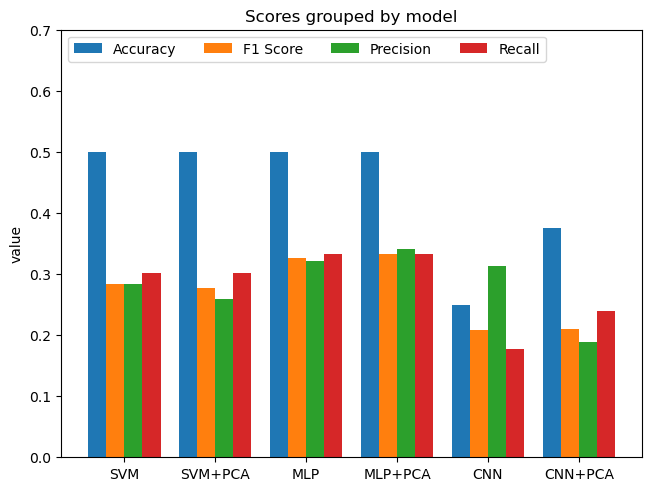

In [53]:
import matplotlib.pyplot as plt
import numpy as np

species = ("Adelie", "Chinstrap", "Gentoo")
scores = {
    'Accuracy': eval_df.test_accuracy,
    'F1 Score': eval_df.test_f1_score,
    'Precision': eval_df.test_precision,
    'Recall': eval_df.test_recall,
}

models = eval_df.model

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('value')
ax.set_title('Scores grouped by model')
ax.set_xticks(x + width + 0.1, models)
ax.legend(loc='upper left', ncols=6)
ax.set_ylim(0, 0.7)

plt.show()

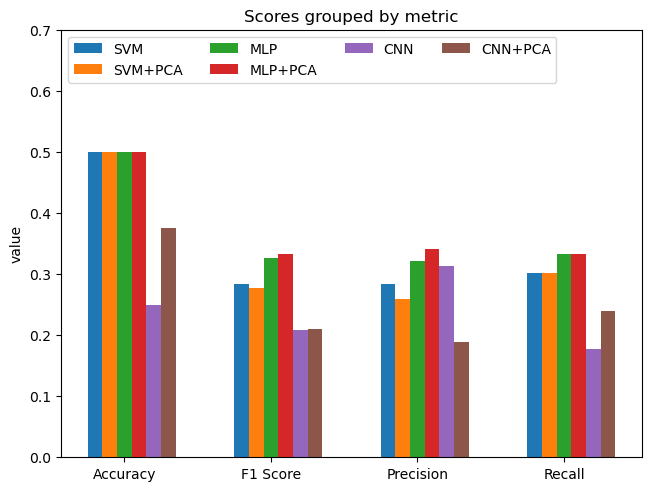

In [54]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ("Accuracy", "F1 Score", "Precision", "Recall")
scores = {
    eval_df.loc[0].to_numpy()[0]: list(eval_df.loc[0].to_numpy()[5:]),
    eval_df.loc[1].to_numpy()[0]: list(eval_df.loc[1].to_numpy()[5:]),
    eval_df.loc[2].to_numpy()[0]: list(eval_df.loc[2].to_numpy()[5:]),
    eval_df.loc[3].to_numpy()[0]: list(eval_df.loc[3].to_numpy()[5:]),
    eval_df.loc[4].to_numpy()[0]: list(eval_df.loc[4].to_numpy()[5:]),
    eval_df.loc[5].to_numpy()[0]: list(eval_df.loc[5].to_numpy()[5:]),
}

models = eval_df.model

x = np.arange(len(metrics))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('value')
ax.set_title('Scores grouped by metric')
ax.set_xticks(x + 0.1 + width, metrics)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 0.7)

plt.show()